# Big Data Tools for Business: Real World Uses Cases Project

## <span style="color:red"> Part 1: Donald Trump Communication Analysis on Twitter 

![Trump.jpg](Trump.jpg)

We are big data analyst for a communication agency who wants to analyze Donald Trump’s communication on Twitter.

The text file trump_tweets.txt contain an history of all trump tweets from 2009 to November 19th, 2020.

Using spark we will explore and analyze this data and get vizualization.

***Summary***

- Top positive and negative words
- Sentiment score
- Top contextual words / hot topics
- Top #
- Top@
- Time analysis

First let's import pyspark and create a SparkContext

In [1]:
import pyspark

sc = pyspark.SparkContext(appName="Trump-Tweets")

We divide our study in two parts analysis based on the text of the tweets then on the date

## <span style="color:blue"> 1 - Text analysis </span>

###  <span style="color:green"> Step 1: Extracting text from the tweets </span>

First we read the trump_tweets.txt file into the RDD rdd_trump_tweets

In [3]:
rdd_trump_tweets = sc.textFile('trump_tweets.txt')

rdd_trump_tweets.take(20)

['Republicans and Democrats have both created our economic problems.;02/08/2011 18:07:48',
 'I was thrilled to be back in the Great city of Charlotte, North Carolina with thousands of hardworking American Patriots who love our Country, cherish our values, respect our laws, and always put AMERICA FIRST! Thank you for a wonderful evening!! #KAG2020 https://t.co/dNJZfRsl9y;03/03/2020 01:34:50',
 'RT @CBS_Herridge: READ: Letter to surveillance court obtained by CBS News questions where there will be further disciplinary action and cho…;17/01/2020 03:22:47',
 'The Unsolicited Mail In Ballot Scam is a major threat to our Democracy, &amp  the Democrats know it. Almost all recent elections using this system, even though much smaller &amp   with far fewer Ballots to count, have ended up being a disaster. Large numbers of missing Ballots &amp  Fraud!;12/09/2020 20:10:58',
 "RT @MZHemingway: Very friendly telling of events here about Comey's apparent leaking to compliant media. If you read those 

We split the lines to isolate the text from the date

In [4]:
rdd_trump_text = rdd_trump_tweets.map(lambda tweet: tweet.split(';')[0])

rdd_trump_text.take(20)

['Republicans and Democrats have both created our economic problems.',
 'I was thrilled to be back in the Great city of Charlotte, North Carolina with thousands of hardworking American Patriots who love our Country, cherish our values, respect our laws, and always put AMERICA FIRST! Thank you for a wonderful evening!! #KAG2020 https://t.co/dNJZfRsl9y',
 'RT @CBS_Herridge: READ: Letter to surveillance court obtained by CBS News questions where there will be further disciplinary action and cho…',
 'The Unsolicited Mail In Ballot Scam is a major threat to our Democracy, &amp  the Democrats know it. Almost all recent elections using this system, even though much smaller &amp   with far fewer Ballots to count, have ended up being a disaster. Large numbers of missing Ballots &amp  Fraud!',
 "RT @MZHemingway: Very friendly telling of events here about Comey's apparent leaking to compliant media. If you read those articles and tho…",
 'RT @WhiteHouse: President @realDonaldTrump announced histo

We split the text into words to run our sentiment analysis

In [5]:
rdd_trump_text_words = rdd_trump_text.flatMap(lambda line:line.split())\
                        .flatMap(lambda line:line.split('.')).flatMap(lambda line:line.split(','))\
                        .flatMap(lambda line:line.split('"')).flatMap(lambda line:line.split('”'))\
                        .flatMap(lambda line:line.split('?')).flatMap(lambda line:line.split('!'))\
                        .flatMap(lambda line:line.split(':'))\
                        .filter(lambda word : word != "").map(lambda word: word.lower())

rdd_trump_text_words.take(20)

['republicans',
 'and',
 'democrats',
 'have',
 'both',
 'created',
 'our',
 'economic',
 'problems',
 'i',
 'was',
 'thrilled',
 'to',
 'be',
 'back',
 'in',
 'the',
 'great',
 'city',
 'of']

Here we create our own list of stop words: some words with no sense doesn't have to be part of the sentiment analysis

In [6]:
list_our_stop_words = ['http','https','//t','rt','@realdonaldtrump','&amp','u','s']

rdd_our_stop_words = sc.parallelize(list_our_stop_words)

rdd_our_stop_words.take(5)

['http', 'https', '//t', 'rt', '@realdonaldtrump']

###  <span style="color:green"> Step 2: Imports stop, negative and positive words and group them by key</span>

In [7]:
rdd_stop_words = sc.textFile('stop-words.txt')

rdd_stop_words.take(10)

['a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost']

In [8]:
rdd_stop_words_kv = rdd_stop_words.map(lambda word: (word,1))

rdd_stop_words_kv.take(10)

[('a', 1),
 ('about', 1),
 ('above', 1),
 ('across', 1),
 ('after', 1),
 ('afterwards', 1),
 ('again', 1),
 ('against', 1),
 ('all', 1),
 ('almost', 1)]

In [9]:
rdd_negative_words = sc.textFile('negative-words.txt')

rdd_negative_words.take(10)

['2-faced',
 '2-faces',
 'abnormal',
 'abolish',
 'abominable',
 'abominably',
 'abominate',
 'abomination',
 'abort',
 'aborted']

In [10]:
rdd_negative_words_kv = rdd_negative_words.map(lambda word: (word,1))

rdd_negative_words_kv.take(10)

[('2-faced', 1),
 ('2-faces', 1),
 ('abnormal', 1),
 ('abolish', 1),
 ('abominable', 1),
 ('abominably', 1),
 ('abominate', 1),
 ('abomination', 1),
 ('abort', 1),
 ('aborted', 1)]

In [11]:
rdd_positive_words = sc.textFile('positive-words.txt')

rdd_positive_words.take(20)

['a+',
 'abound',
 'abounds',
 'abundance',
 'abundant',
 'accessable',
 'accessible',
 'acclaim',
 'acclaimed',
 'acclamation',
 'accolade',
 'accolades',
 'accommodative',
 'accomodative',
 'accomplish',
 'accomplished',
 'accomplishment',
 'accomplishments',
 'accurate',
 'accurately']

The word "trump" is included in the positive words and, as it's the name of the president, it must be removed from the list so not to distort our study because it's one of the most used words in his tweets and retweets

In [12]:
list_positive_words_to_remove = ['trump']

rdd_positive_words_to_remove = sc.parallelize(list_positive_words_to_remove)

rdd_positive_words = rdd_positive_words.subtract(rdd_positive_words_to_remove)

In [13]:
rdd_positive_words_kv = rdd_positive_words.map(lambda word: (word,1))

rdd_positive_words_kv.take(20)

[('abound', 1),
 ('accessable', 1),
 ('accessible', 1),
 ('accomplishment', 1),
 ('achievements', 1),
 ('acumen', 1),
 ('adroit', 1),
 ('adroitly', 1),
 ('adulatory', 1),
 ('advantageously', 1),
 ('affirmation', 1),
 ('afordable', 1),
 ('agilely', 1),
 ('all-around', 1),
 ('ambitiously', 1),
 ('amply', 1),
 ('appealing', 1),
 ('appreciates', 1),
 ('astoundingly', 1),
 ('attune', 1)]

In [14]:
rdd_trump_text_words_kv = rdd_trump_text_words.map(lambda word: (word,1))

rdd_trump_text_words_kv.take(20)


[('republicans', 1),
 ('and', 1),
 ('democrats', 1),
 ('have', 1),
 ('both', 1),
 ('created', 1),
 ('our', 1),
 ('economic', 1),
 ('problems', 1),
 ('i', 1),
 ('was', 1),
 ('thrilled', 1),
 ('to', 1),
 ('be', 1),
 ('back', 1),
 ('in', 1),
 ('the', 1),
 ('great', 1),
 ('city', 1),
 ('of', 1)]

###  <span style="color:green"> Step 3: Extract top negative and positive words</span>

### Top positive words

We join the positive words and words from the tweets

In [15]:
rdd_trump_text_words_positive = rdd_positive_words_kv.join(rdd_trump_text_words_kv).mapValues(lambda tuple: 1)

rdd_trump_text_words_positive.take(10)

[('authentic', 1),
 ('booming', 1),
 ('booming', 1),
 ('booming', 1),
 ('booming', 1),
 ('booming', 1),
 ('booming', 1),
 ('booming', 1),
 ('booming', 1),
 ('booming', 1)]

We reduce by key and sort by descending order based on the count to get the occurrences of each positive word in the tweets

In [16]:
rdd_trump_text_words_positive_count_ordered = rdd_trump_text_words_positive.reduceByKey(lambda x,y : x+y)\
                                                        .sortBy(lambda tuple: tuple[1], ascending=False)

list_top_positives_opinion = rdd_trump_text_words_positive_count_ordered.take(20)

list_top_positives_opinion

[('great', 7464),
 ('thank', 3525),
 ('like', 2005),
 ('good', 1816),
 ('best', 1234),
 ('love', 1160),
 ('win', 1118),
 ('work', 1014),
 ('right', 934),
 ('better', 851),
 ('well', 757),
 ('strong', 734),
 ('support', 673),
 ('amazing', 647),
 ('congratulations', 598),
 ('nice', 580),
 ('happy', 577),
 ('honor', 500),
 ('wow', 495),
 ('wonderful', 482)]

### Top negative words

We follow the same procedure for negative words too

In [17]:
rdd_trump_text_words_negative = rdd_negative_words_kv.join(rdd_trump_text_words_kv).mapValues(lambda tuple: 1)

rdd_trump_text_words_negative.take(10)

[('absentee', 1),
 ('absentee', 1),
 ('absentee', 1),
 ('absentee', 1),
 ('absentee', 1),
 ('absentee', 1),
 ('absentee', 1),
 ('absentee', 1),
 ('absentee', 1),
 ('absentee', 1)]

In [18]:
rdd_trump_text_words_negative_count_ordered = rdd_trump_text_words_negative.reduceByKey(lambda x,y : x+y)\
                                                    .sortBy(lambda tuple: tuple[1], ascending=False)

list_top_negatives_opinion = rdd_trump_text_words_negative_count_ordered.take(20)

list_top_negatives_opinion

[('fake', 1214),
 ('bad', 999),
 ('hard', 751),
 ('crime', 554),
 ('wrong', 449),
 ('crooked', 447),
 ('illegal', 420),
 ('radical', 385),
 ('terrible', 384),
 ('lost', 369),
 ('corrupt', 354),
 ('collusion', 349),
 ('sad', 330),
 ('disaster', 310),
 ('problem', 302),
 ('hoax', 297),
 ('crazy', 290),
 ('attack', 283),
 ('miss', 277),
 ('failed', 267)]

###  <span style="color:green"> Step 4: Vizualization and sentiment score</span>

We create a function to plot the positive and negative words

In [19]:
from matplotlib import pyplot as plt
import seaborn as sb

import pandas as pd

def plot_opinion(list_positives, list_negatives):
    
    list_1 = [(t[0], t[1], 'positive') for t in list_positives]
    list_2 = [(t[0], t[1], 'negative') for t in list_negatives]
    
     
    list_1.extend(list_2)
    
    
    pd_df = pd.DataFrame({
     'Opinion': [ t[0] for t in list_1 ],
     'Count': [ t[1] for t in list_1 ],
     'polarity': [ t[2] for t in list_1 ]
    }).sort_values('Count', ascending=False)
    
    pd_df['color'] = pd_df.polarity.apply(lambda polarity: 'green' if polarity=='positive' else 'red')
    
    plt.figure( figsize = (15, 8) )
    chart=sb.barplot(data=pd_df, x='Opinion', y='Count', hue='polarity', palette=["green", "red"], order=pd_df['Opinion'])
    chart.set_xticklabels(
    chart.get_xticklabels(), 
    rotation=80, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large',
    )
    
    for tick, color in zip(chart.get_xticklabels(), pd_df['color']): 
        tick.set_color(color)
    
    plt.show()

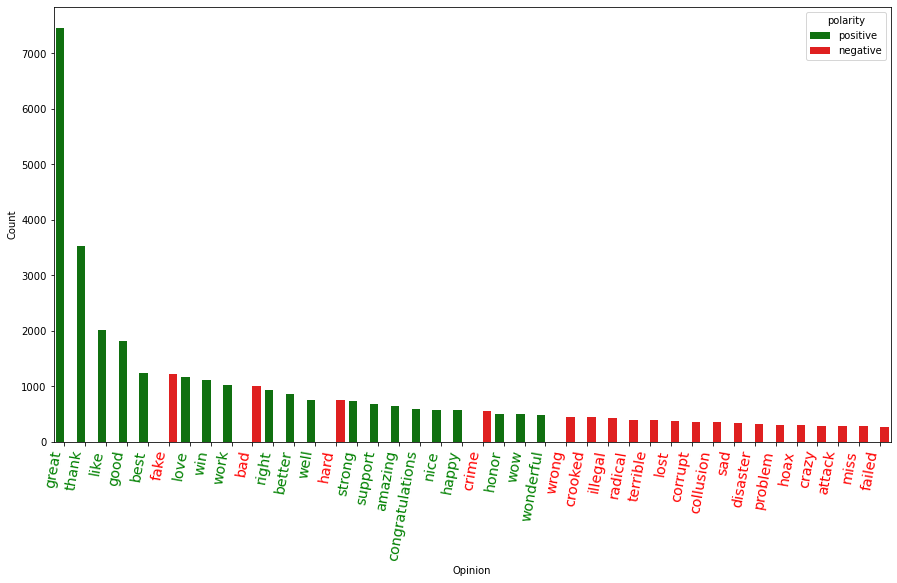

In [20]:
plot_opinion(list_top_positives_opinion, list_top_negatives_opinion)

We can already see from this graph that Trump uses far more positive words in his tweets than negative ones, so we can expect a positive sentiment score.
This might be surprising as Trump is seen as a very nervous president and we might expect a negative sentiment score: however, he probably uses a different tone on Twitter than we see him on TV, so we will probably have a positive score.

We compute the global sentiment score: the difference between the number of positive words and the number of negative words

In [21]:
sentiment_score = rdd_trump_text_words_positive.map(lambda tuple: tuple[1]).sum()\
                  - rdd_trump_text_words_negative.map(lambda tuple: tuple[1]).sum()

print('The sentiment score is : ',sentiment_score)

The sentiment score is :  19355


Our previous assumptions were confirmed with a rather high sentiment score

###  <span style="color:green"> Step 5: The contextual words</span>

We study and count the occurrence of words that are neither negative nor positive and are called contextual words

We remove all the positive, negative and stop words from the tweets words to keep only the contextual words

In [22]:
rdd_trump_text_contextual_words = rdd_trump_text_words.subtract(rdd_positive_words).subtract(rdd_negative_words).subtract(rdd_stop_words).subtract(rdd_our_stop_words).subtract(rdd_positive_words_to_remove)

rdd_trump_text_contextual_words.take(20)

['co/ai2vtb1v3g',
 '@foxandfriends',
 '@foxandfriends',
 '@foxandfriends',
 '@foxandfriends',
 '@foxandfriends',
 '@foxandfriends',
 '@foxandfriends',
 '@foxandfriends',
 '@foxandfriends',
 '@foxandfriends',
 '@foxandfriends',
 '@foxandfriends',
 '@foxandfriends',
 '@foxandfriends',
 '@foxandfriends',
 '@foxandfriends',
 '@foxandfriends',
 '@foxandfriends',
 '@foxandfriends']

We assign on each word a value of 1 and reduce by key to obtain the occurences of contextual words, sorted by descending order

In [23]:
rdd_trump_text_contextual_words_ordered = rdd_trump_text_contextual_words.map(lambda word: (word, 1))\
                                                 .reduceByKey(lambda x,y : x+y)\
                                                 .sortBy(lambda tuple: tuple[1], ascending=False)

list_top_contextual_words = rdd_trump_text_contextual_words_ordered.take(50)  

list_top_contextual_words

[('president', 4501),
 ('people', 3365),
 ('just', 3280),
 ('new', 2477),
 ('country', 2255),
 ('thanks', 2183),
 ('america', 2170),
 ('big', 2054),
 ('time', 1887),
 ('make', 1835),
 ('news', 1763),
 ('donald', 1713),
 ('democrats', 1694),
 ('vote', 1658),
 ('obama', 1651),
 ('today', 1628),
 ('going', 1521),
 ('want', 1409),
 ('american', 1400),
 ('years', 1266),
 ('job', 1255),
 ('run', 1254),
 ('need', 1204),
 ('doing', 1175),
 ('media', 1128),
 ('think', 1123),
 ('china', 1122),
 ('way', 1098),
 ('really', 1095),
 ('did', 1079),
 ('know', 1075),
 ('day', 1071),
 ('house', 1049),
 ('jobs', 1027),
 ('said', 1005),
 ('states', 985),
 ('true', 983),
 ('election', 973),
 ('border', 968),
 ('deal', 951),
 ('state', 946),
 ('world', 939),
 ('@foxnews', 927),
 ('biden', 910),
 ('hillary', 903),
 ("don't", 902),
 ('tonight', 900),
 ('watch', 898),
 ('united', 868),
 ('@whitehouse', 836)]

We create a function to plot the contextual words

In [24]:
def plot_contextual_words(list_contextual_words):
    
    pd_df = pd.DataFrame({
        'Word':  [ t[0] for t in list_contextual_words ],
        'Count': [ t[1] for t in list_contextual_words ]
    }).sort_values('Count', ascending=False)
    
    plt.figure( figsize = (15, 8) )
    
    chart=sb.barplot(data=pd_df, x='Word', y='Count', order=pd_df['Word'], color='blue')
    
    chart.set_xticklabels(
        chart.get_xticklabels(), 
        rotation=80, 
        horizontalalignment='right',
        fontweight='light',
        fontsize='x-large',
        )
    
    plt.show()

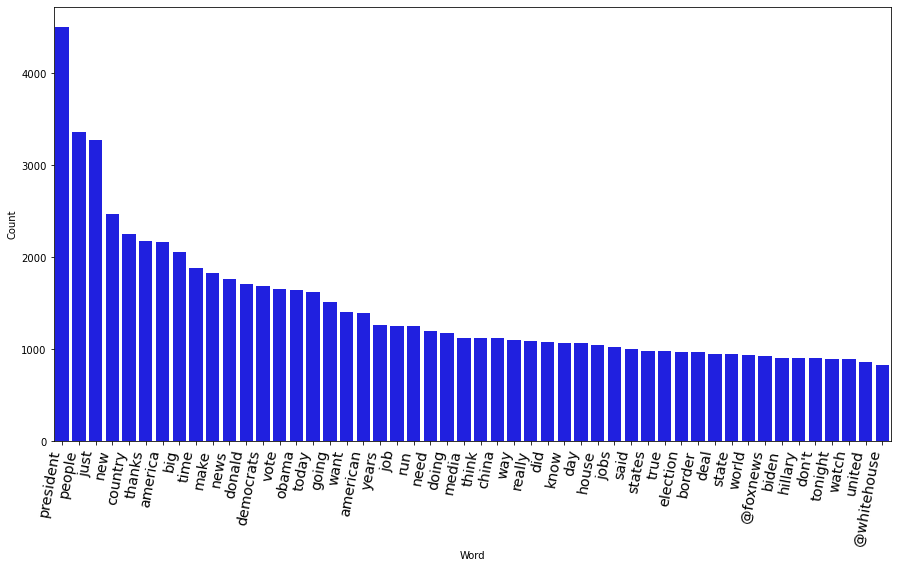

In [25]:
plot_contextual_words(list_top_contextual_words)

From the words most used by Trump, we can see that his speeches are mainly focused on politics (as we expected): frequently used words are "president", "people", "America", "democrats", "votes", "Obama", "China", "border", "Biden"....

We use a wordcloud to get another visualization

In [26]:
#pip install wordcloud

In [27]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd

In [28]:
def plot_cloud(list_):
    wordcloud = WordCloud(width = 1500, height = 500, random_state=1, background_color='white', colormap='Set2', collocations=False).generate_from_frequencies(dict(list_))
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off")
    plt.show();

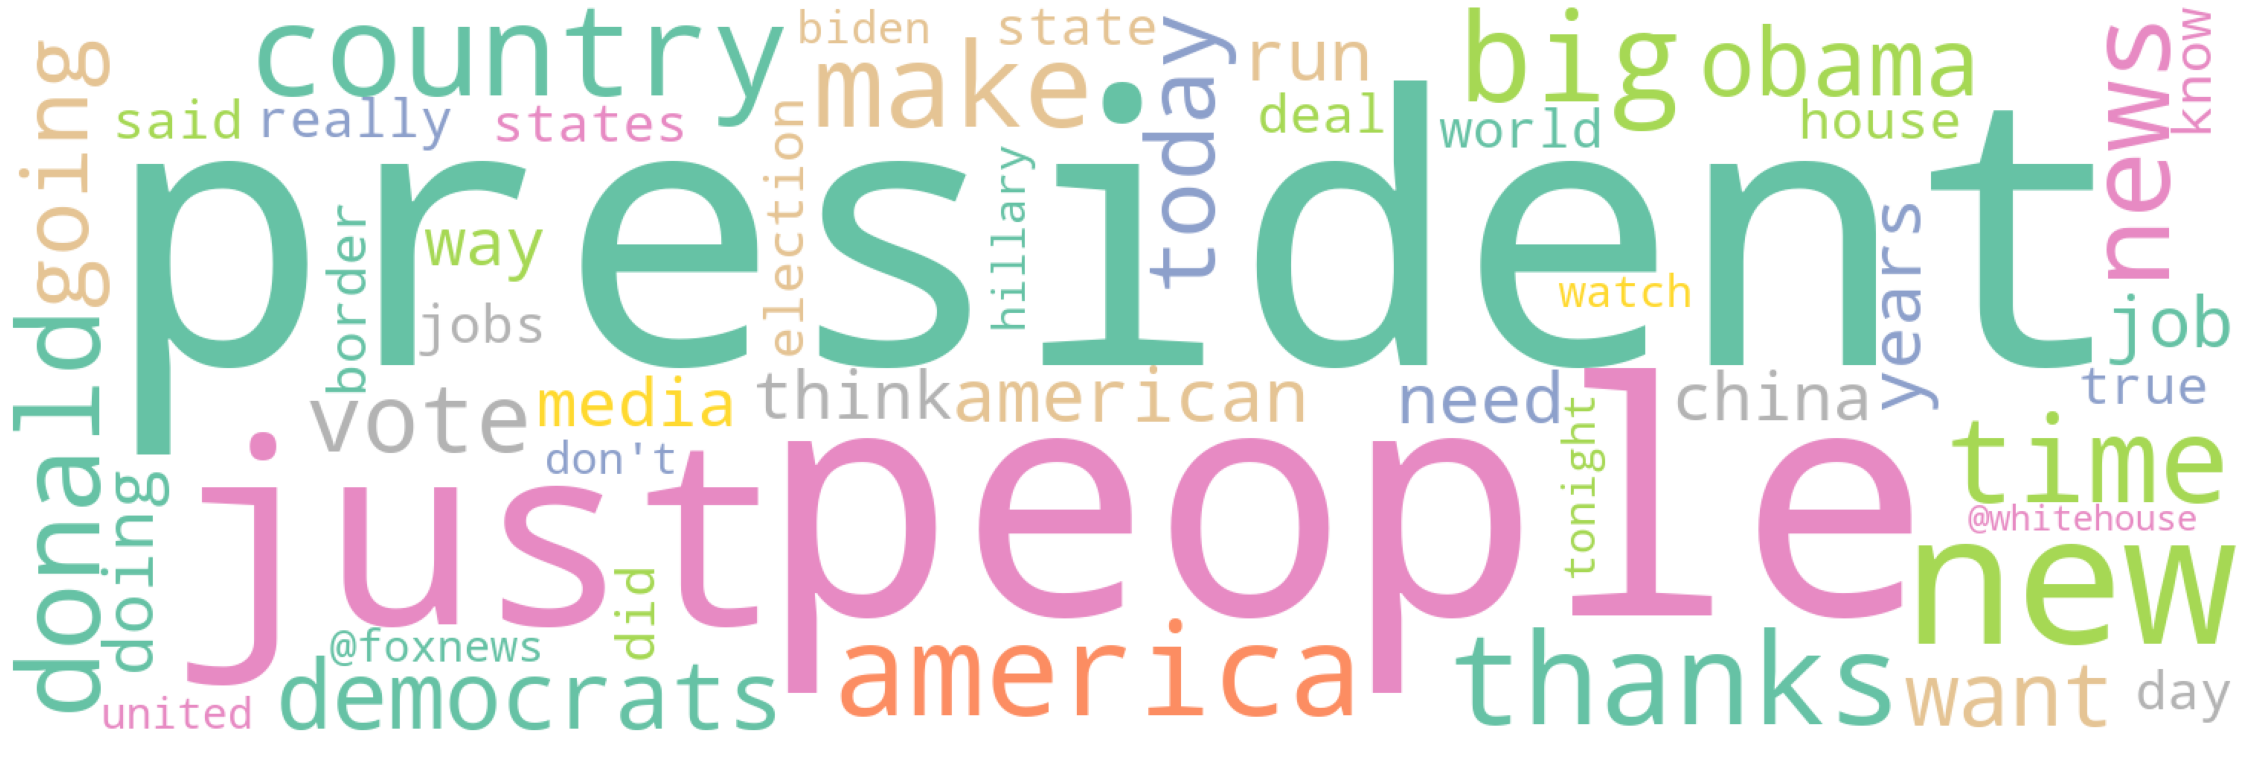

In [29]:
plot_cloud(list_top_contextual_words)

###  <span style="color:green"> Step 6: Hot topics</span>

We wanted to focus our study on what seemed to us to be hot topics, namely covid-19 then the presidential elections.

### The covid-19

We filter and keep only the tweets containing the word covid

In [30]:
rdd_trump_text_covid = rdd_trump_text.map(lambda word: word.lower()).filter(lambda line:'covid' in line)

rdd_trump_text_covid.take(20)

['joe biden’s response to the h1n1 swine flu, far less lethal than covid 19, was one of the weakest and worst in the history of fighting epidemics and pandemics. it was pathetic, those involved have said. joe didn’t have a clue!',
 'rt @drmarcsiegel: my new book separates fact from fiction in the covid-19 epidemic. covid: the politics of fear and the power of science is…',
 'rt @therightmelissa: @realdonaldtrump the nerve of gov. cuomo trying to capitalize on covid after he killed 1000’s in the nursing homes?? n…',
 'governor cuomo has shown tremendously poor leadership skills in running n.y. bad time for him to be writing and promoting a book, especially since he has done such a poor job with covid and crime. so many unnecessary deaths. the city &amp  state have sunk to historic lows...',
 'the great bobby bowden, one of the best coaches ever in college football, on his full recovery from covid-19 “....america is the greatest country this side of heaven. i’ve had a chance to get a lot

In [31]:
rdd_trump_text_covid_words = rdd_trump_text_covid.flatMap(lambda line:line.split())\
                        .flatMap(lambda line:line.split('.')).flatMap(lambda line:line.split(','))\
                        .flatMap(lambda line:line.split('"')).flatMap(lambda line:line.split('”'))\
                        .flatMap(lambda line:line.split('?')).flatMap(lambda line:line.split('!'))\
                        .flatMap(lambda line:line.split(':'))\
                        .filter(lambda word : word != "")

rdd_trump_text_covid_words.take(20)

['joe',
 'biden’s',
 'response',
 'to',
 'the',
 'h1n1',
 'swine',
 'flu',
 'far',
 'less',
 'lethal',
 'than',
 'covid',
 '19',
 'was',
 'one',
 'of',
 'the',
 'weakest',
 'and']

In [32]:
rdd_trump_text_covid_words_kv = rdd_trump_text_covid_words.map(lambda word: (word,1))

rdd_trump_text_covid_words_kv.take(20)


[('joe', 1),
 ('biden’s', 1),
 ('response', 1),
 ('to', 1),
 ('the', 1),
 ('h1n1', 1),
 ('swine', 1),
 ('flu', 1),
 ('far', 1),
 ('less', 1),
 ('lethal', 1),
 ('than', 1),
 ('covid', 1),
 ('19', 1),
 ('was', 1),
 ('one', 1),
 ('of', 1),
 ('the', 1),
 ('weakest', 1),
 ('and', 1)]

Then we join the tweets words with positive and negative words

In [33]:
rdd_trump_text_covid_words_positive = rdd_positive_words_kv.join(rdd_trump_text_covid_words_kv).mapValues(lambda tuple: 1)

rdd_trump_text_covid_words_positive.take(10)

[('free', 1),
 ('right', 1),
 ('right', 1),
 ('advantages', 1),
 ('proactive', 1),
 ('grateful', 1),
 ('grateful', 1),
 ('like', 1),
 ('like', 1),
 ('like', 1)]

In [34]:
rdd_trump_text_covid_words_positive_count = rdd_trump_text_covid_words_positive.reduceByKey(lambda x,y : x+y)

rdd_trump_text_covid_words_positive_count.take(20)

[('free', 1),
 ('right', 2),
 ('advantages', 1),
 ('proactive', 1),
 ('grateful', 2),
 ('like', 5),
 ('pleased', 1),
 ('wonderful', 1),
 ('faster', 1),
 ('confidence', 1),
 ('encouraging', 3),
 ('works', 1),
 ('stable', 1),
 ('honor', 1),
 ('significant', 2),
 ('tremendously', 1),
 ('helping', 1),
 ('positive', 5),
 ('available', 2),
 ('enough', 1)]

In [35]:
rdd_trump_text_covid_words_positive_count_ordered = rdd_trump_text_covid_words_positive_count.sortBy(lambda tuple: tuple[1], ascending=False)

list_top_covid_positive_opinion = rdd_trump_text_covid_words_positive_count_ordered.take(20)

list_top_covid_positive_opinion

[('great', 13),
 ('support', 8),
 ('good', 7),
 ('thank', 6),
 ('like', 5),
 ('positive', 5),
 ('work', 5),
 ('strong', 4),
 ('relief', 4),
 ('encouraging', 3),
 ('important', 3),
 ('effective', 3),
 ('win', 3),
 ('protect', 3),
 ('better', 3),
 ('right', 2),
 ('grateful', 2),
 ('significant', 2),
 ('available', 2),
 ('well', 2)]

In [36]:
rdd_trump_text_covid_words_negative = rdd_negative_words_kv.join(rdd_trump_text_covid_words_kv).mapValues(lambda tuple: 1)

rdd_trump_text_covid_words_negative.take(10)

[('absentee', 1),
 ('confusion', 1),
 ('disaster', 1),
 ('drastically', 1),
 ('emergency', 1),
 ('emergency', 1),
 ('emergency', 1),
 ('epidemic', 1),
 ('fraud', 1),
 ('gross', 1)]

In [37]:
rdd_trump_text_covid_words_negative_count = rdd_trump_text_covid_words_negative.reduceByKey(lambda x,y : x+y)

rdd_trump_text_covid_words_negative_count.take(20)

[('absentee', 1),
 ('confusion', 1),
 ('disaster', 1),
 ('drastically', 1),
 ('emergency', 3),
 ('epidemic', 1),
 ('fraud', 1),
 ('gross', 1),
 ('horrible', 1),
 ('illegal', 1),
 ('impossible', 1),
 ('infected', 1),
 ('killed', 1),
 ('loss', 1),
 ('lost', 2),
 ('mistake', 1),
 ('pathetic', 1),
 ('poorly', 1),
 ('rejecting', 1),
 ('risk', 4)]

In [38]:
rdd_trump_text_covid_words_negative_count_ordered = rdd_trump_text_covid_words_negative_count.sortBy(lambda tuple: tuple[1], ascending=False)

list_top_covid_negative_opinion = rdd_trump_text_covid_words_negative_count_ordered.take(20)

list_top_covid_negative_opinion

[('fake', 12),
 ('death', 6),
 ('outbreak', 6),
 ('slow', 5),
 ('risk', 4),
 ('hard', 4),
 ('symptoms', 4),
 ('virus', 4),
 ('emergency', 3),
 ('breaking', 3),
 ('crisis', 3),
 ('poor', 3),
 ('problem', 3),
 ('lost', 2),
 ('bad', 2),
 ('break', 2),
 ('illness', 2),
 ('lies', 2),
 ('losers', 2),
 ('outrageous', 2)]

We create a function to plot the positive and negative words

In [39]:
from matplotlib import pyplot as plt
import seaborn as sb

import pandas as pd

def plot_opinion_covid(list_positives, list_negatives):
    
    list_1 = [(t[0], t[1], 'positive') for t in list_positives]
    list_2 = [(t[0], t[1], 'negative') for t in list_negatives]
    
     
    list_1.extend(list_2)
    
    
    pd_df = pd.DataFrame({
     'Opinion': [ t[0] for t in list_1 ],
     'Count': [ t[1] for t in list_1 ],
     'polarity': [ t[2] for t in list_1 ]
    }).sort_values('Count', ascending=False)
    
    pd_df['color'] = pd_df.polarity.apply(lambda polarity: 'green' if polarity=='positive' else 'red')
    
    plt.figure( figsize = (15, 8) )
    chart=sb.barplot(data=pd_df, x='Opinion', y='Count', hue='polarity', palette=["green", "red"], order=pd_df['Opinion'])
    chart.set_xticklabels(
    chart.get_xticklabels(), 
    rotation=80, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large',
    )
    
    for tick, color in zip(chart.get_xticklabels(), pd_df['color']): 
        tick.set_color(color)
    
    plt.show()

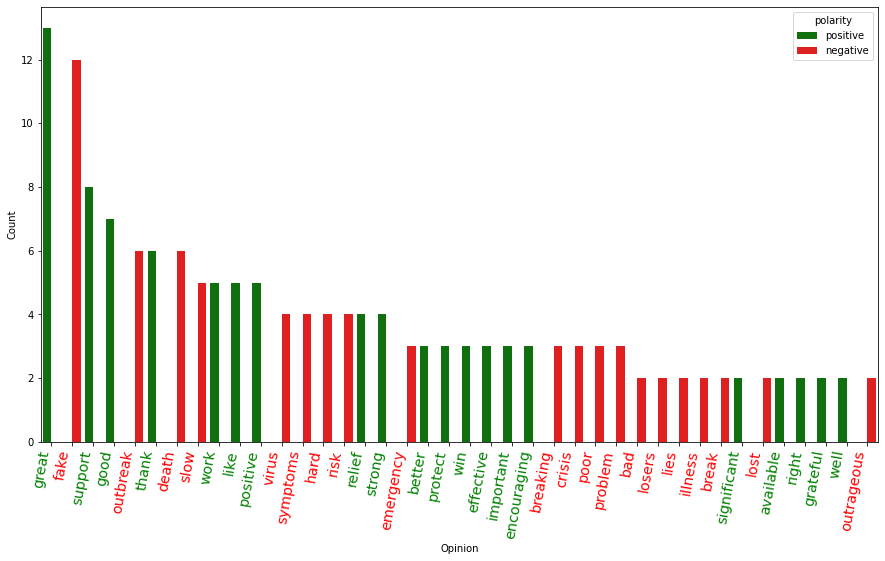

In [40]:
plot_opinion_covid(list_top_covid_positive_opinion, list_top_covid_negative_opinion)

In this graph we can see that there is a higher number of negative words, which is understandable in view of the subject. It would seem that President Trump is less positive and he is worried in relation to the topic of Covid-19: very negative words are used in his tweets like "death", "virus", "hard", "risk", "emergency", "crisis".

In [41]:
sentiment_score_covid = rdd_trump_text_covid_words_positive_count.map(lambda tuple: tuple[1]).sum()\
                  - rdd_trump_text_covid_words_negative_count.map(lambda tuple: tuple[1]).sum()

print('The sentiment score is : ',sentiment_score_covid)

The sentiment score is :  -13


Our previous assumptions were confirmed with a more neutral sentiment score.

We create a list of words that need to be removed from our studies. These words are linked to the word covid and are of no interest.

In [42]:
list_our_stop_words_covid = ['#covid19','covid','covid-19','19']

rdd_our_stop_words_covid = sc.parallelize(list_our_stop_words_covid)

rdd_our_stop_words_covid.take(5)

['#covid19', 'covid', 'covid-19', '19']

In [43]:
rdd_trump_text_covid_contextual_words = rdd_trump_text_covid_words.subtract(rdd_positive_words).subtract(rdd_negative_words).subtract(rdd_stop_words).subtract(rdd_our_stop_words).subtract(rdd_our_stop_words_covid)

rdd_trump_text_covid_contextual_words.take(20)

['bobby',
 'narrative',
 'narrative',
 '@foxandfriends',
 'tre…',
 'guest',
 'start',
 'dod’s',
 'family',
 '(and',
 '“to',
 'texas',
 'texas',
 'utilize',
 'maintain…',
 'guard',
 'los',
 'com…',
 '#clinicaltrial',
 '#clinicaltrial']

In [44]:
rdd_trump_text_covid_contextual_words_ordered = rdd_trump_text_covid_contextual_words.map(lambda word: (word, 1))\
                                                 .reduceByKey(lambda x,y : x+y)\
                                                 .sortBy(lambda tuple: tuple[1], ascending=False)

list_top_contextual_covid_words = rdd_trump_text_covid_contextual_words_ordered.take(20)  

list_top_contextual_covid_words

[('new', 18),
 ('@cdcgov', 18),
 ('news', 16),
 ('people', 15),
 ('spread', 14),
 ('help', 14),
 ('media', 13),
 ('response', 10),
 ('just', 10),
 ('today', 9),
 ('vaccine', 9),
 ('election', 8),
 ('testing', 8),
 ('trump', 8),
 ('000', 8),
 ('states', 8),
 ('cases', 7),
 ('covid19', 7),
 ('working', 7),
 ('@whitehouse', 7)]

We create a function to plot the most common contextual words

In [45]:
def plot_contextual_covid_words(list_contextual_words):
    
    pd_df = pd.DataFrame({
        'Word':  [ t[0] for t in list_contextual_words ],
        'Count': [ t[1] for t in list_contextual_words ]
    }).sort_values('Count', ascending=False)
    
    plt.figure( figsize = (15, 8) )
    
    chart=sb.barplot(data=pd_df, x='Word', y='Count', order=pd_df['Word'], color='blue')
    
    chart.set_xticklabels(
        chart.get_xticklabels(), 
        rotation=80, 
        horizontalalignment='right',
        fontweight='light',
        fontsize='x-large',
        )
    
    plt.show()

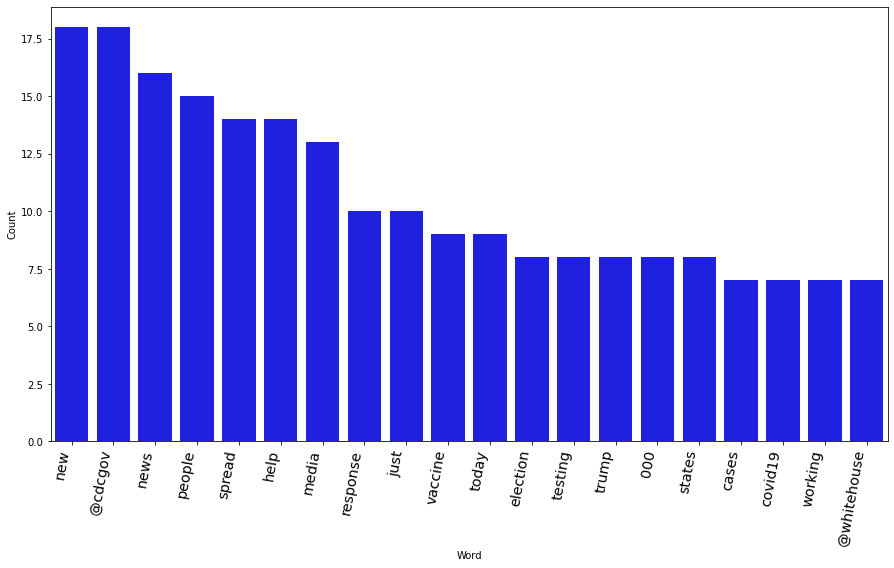

In [46]:
plot_contextual_covid_words(list_top_contextual_covid_words)

All the contextual words are related to Covid-19, the health emergency, the possible vaccine and also the influence the pandemic may have on the political world (elections).

### The presidential elections

We filter and keep only the tweets containing the word election

In [47]:
rdd_trump_text_election = rdd_trump_text.map(lambda word: word.lower()).filter(lambda line:'election' in line)

rdd_trump_text_election.take(10)


['the unsolicited mail in ballot scam is a major threat to our democracy, &amp  the democrats know it. almost all recent elections using this system, even though much smaller &amp   with far fewer ballots to count, have ended up being a disaster. large numbers of missing ballots &amp  fraud!',
 'rt @chefjclark: people ask why the president fights so hard in court for ballot integrity?  why we have such an extensive election day oper…',
 'what a terrible thing for biden to say! rigged election? https://t.co/jqxxeqczu9',
 'this is the most important election in the history of our country. with your vote, we will continue to bring back your jobs, lower drug prices, support our police, protect the #2a, defend our borders, and ensure more products are proudly stamped with the phrase made in the usa! https://t.co/m0ba8qr7nl',
 'rt @texasgop: report any irregularities to the republican party of texas voter helpline: 855-433-1663 #earlyvoting #vote #election2020 http…',
 '“a pennsylvania appea

In [48]:
rdd_trump_text_election_words = rdd_trump_text_election.flatMap(lambda line:line.split())\
                        .flatMap(lambda line:line.split('.')).flatMap(lambda line:line.split(','))\
                        .flatMap(lambda line:line.split('"')).flatMap(lambda line:line.split('”'))\
                        .flatMap(lambda line:line.split('?')).flatMap(lambda line:line.split('!'))\
                        .flatMap(lambda line:line.split(':'))\
                        .filter(lambda word : word != "")

rdd_trump_text_election_words.take(20)

['the',
 'unsolicited',
 'mail',
 'in',
 'ballot',
 'scam',
 'is',
 'a',
 'major',
 'threat',
 'to',
 'our',
 'democracy',
 '&amp',
 'the',
 'democrats',
 'know',
 'it',
 'almost',
 'all']

In [49]:
rdd_trump_text_election_words_kv = rdd_trump_text_election_words.map(lambda word: (word,1))

rdd_trump_text_election_words_kv.take(20)


[('the', 1),
 ('unsolicited', 1),
 ('mail', 1),
 ('in', 1),
 ('ballot', 1),
 ('scam', 1),
 ('is', 1),
 ('a', 1),
 ('major', 1),
 ('threat', 1),
 ('to', 1),
 ('our', 1),
 ('democracy', 1),
 ('&amp', 1),
 ('the', 1),
 ('democrats', 1),
 ('know', 1),
 ('it', 1),
 ('almost', 1),
 ('all', 1)]

In [50]:
rdd_trump_text_election_words_positive = rdd_positive_words_kv.join(rdd_trump_text_election_words_kv).mapValues(lambda tuple: 1)

rdd_trump_text_election_words_positive.take(10)

[('booming', 1),
 ('booming', 1),
 ('free', 1),
 ('free', 1),
 ('free', 1),
 ('free', 1),
 ('led', 1),
 ('right', 1),
 ('right', 1),
 ('right', 1)]

In [51]:
rdd_trump_text_election_words_positive_count = rdd_trump_text_election_words_positive.reduceByKey(lambda x,y : x+y)

rdd_trump_text_election_words_positive_count.take(20)

[('booming', 2),
 ('free', 4),
 ('led', 1),
 ('right', 21),
 ('willing', 3),
 ('leading', 5),
 ('smart', 7),
 ('admirable', 1),
 ('conveniently', 2),
 ('excellent', 2),
 ('capable', 1),
 ('grateful', 2),
 ('like', 40),
 ('liked', 3),
 ('pleased', 1),
 ('safe', 6),
 ('stunning', 1),
 ('competitive', 2),
 ('fearless', 2),
 ('genius', 1)]

In [52]:
rdd_trump_text_election_words_positive_count_ordered = rdd_trump_text_election_words_positive_count.sortBy(lambda tuple: tuple[1], ascending=False)

list_top_election_positive_opinion = rdd_trump_text_election_words_positive_count_ordered.take(20)

list_top_election_positive_opinion

[('great', 122),
 ('win', 113),
 ('won', 61),
 ('like', 40),
 ('important', 32),
 ('wins', 32),
 ('strong', 29),
 ('thank', 29),
 ('good', 27),
 ('best', 24),
 ('support', 22),
 ('right', 21),
 ('well', 21),
 ('better', 19),
 ('victory', 17),
 ('work', 17),
 ('tough', 16),
 ('winning', 16),
 ('greatest', 16),
 ('lead', 15)]

In [53]:
rdd_trump_text_election_words_negative = rdd_negative_words_kv.join(rdd_trump_text_election_words_kv).mapValues(lambda tuple: 1)

rdd_trump_text_election_words_negative.take(10)

[('absentee', 1),
 ('absentee', 1),
 ('absentee', 1),
 ('absentee', 1),
 ('absentee', 1),
 ('absentee', 1),
 ('absentee', 1),
 ('absentee', 1),
 ('absentee', 1),
 ('absentee', 1)]

In [54]:
rdd_trump_text_election_words_negative_count = rdd_trump_text_election_words_negative.reduceByKey(lambda x,y : x+y)

rdd_trump_text_election_words_negative_count.take(20)

[('absentee', 11),
 ('anti-us', 1),
 ('bizarre', 1),
 ('blatant', 1),
 ('chaos', 2),
 ('concede', 1),
 ('conceded', 3),
 ('concerns', 2),
 ('confusion', 1),
 ('conservative', 1),
 ('costly', 1),
 ('crazy', 10),
 ('crushing', 1),
 ('denying', 1),
 ('detrimental', 1),
 ('disaster', 14),
 ('discredit', 1),
 ('disgrace', 1),
 ('dishonest', 4),
 ('dismal', 1)]

In [55]:
rdd_trump_text_election_words_negative_count_ordered = rdd_trump_text_election_words_negative_count.sortBy(lambda tuple: tuple[1], ascending=False)

list_top_election_negative_opinion = rdd_trump_text_election_words_negative_count_ordered.take(20)

list_top_election_negative_opinion

[('fake', 65),
 ('fraud', 33),
 ('bad', 32),
 ('crooked', 31),
 ('lost', 29),
 ('crime', 28),
 ('hard', 24),
 ('wrong', 23),
 ('collusion', 20),
 ('corrupt', 18),
 ('excuse', 18),
 ('steal', 18),
 ('illegal', 17),
 ('breaking', 15),
 ('phony', 15),
 ('disaster', 14),
 ('lose', 14),
 ('hoax', 14),
 ('radical', 14),
 ('illegally', 13)]

We create a function to plot the positive and negative words

In [56]:
from matplotlib import pyplot as plt
import seaborn as sb

import pandas as pd

def plot_opinion_election(list_positives, list_negatives):
    
    list_1 = [(t[0], t[1], 'positive') for t in list_positives]
    list_2 = [(t[0], t[1], 'negative') for t in list_negatives]
    
     
    list_1.extend(list_2)
    
    
    pd_df = pd.DataFrame({
     'Opinion': [ t[0] for t in list_1 ],
     'Count': [ t[1] for t in list_1 ],
     'polarity': [ t[2] for t in list_1 ]
    }).sort_values('Count', ascending=False)
    
    pd_df['color'] = pd_df.polarity.apply(lambda polarity: 'green' if polarity=='positive' else 'red')
    
    plt.figure( figsize = (15, 8) )
    chart=sb.barplot(data=pd_df, x='Opinion', y='Count', hue='polarity', palette=["green", "red"], order=pd_df['Opinion'])
    chart.set_xticklabels(
    chart.get_xticklabels(), 
    rotation=80, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large',
    )
    
    for tick, color in zip(chart.get_xticklabels(), pd_df['color']): 
        tick.set_color(color)
    
    plt.show()

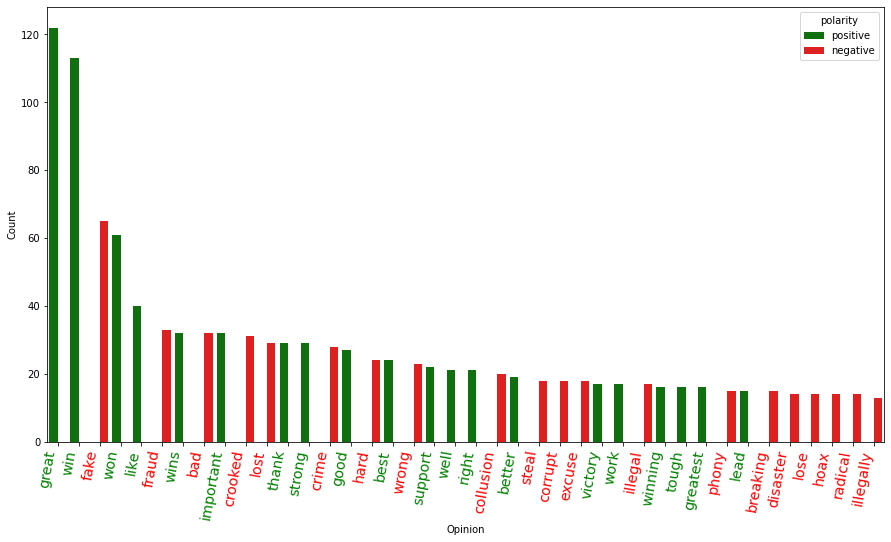

In [57]:
plot_opinion_election(list_top_election_positive_opinion, list_top_election_negative_opinion)

There is a mix of positive and negative words related to the election, Trump does not have a firm opinion about it and most importantly a more thorough study should be done to distinguish the 2016 and 2020 elections.

In [58]:
sentiment_score_election = rdd_trump_text_election_words_positive_count.map(lambda tuple: tuple[1]).sum()\
                  - rdd_trump_text_election_words_negative_count.map(lambda tuple: tuple[1]).sum()

print('The sentiment score is : ',sentiment_score_election)

The sentiment score is :  -62


In [59]:
list_our_stop_words_election = ['election']

rdd_our_stop_words_election = sc.parallelize(list_our_stop_words_election)

rdd_our_stop_words_election.take(5)

['election']

In [60]:
rdd_trump_text_election_contextual_words = rdd_trump_text_election_words.subtract(rdd_positive_words).subtract(rdd_negative_words).subtract(rdd_stop_words).subtract(rdd_our_stop_words).subtract(rdd_our_stop_words_election)

rdd_trump_text_election_contextual_words.take(20)

['24',
 '24',
 '24',
 '@foxandfriends',
 '@foxandfriends',
 '@foxandfriends',
 '@foxandfriends',
 '@foxandfriends',
 '@foxandfriends',
 '@foxandfriends',
 '@foxandfriends',
 '@foxandfriends',
 '@foxandfriends',
 'caight',
 '(we',
 '@zedd_tahlz',
 '@the_lady_colors',
 'narrative',
 'narrative',
 'narrative']

In [61]:
rdd_trump_text_election_contextual_words_ordered = rdd_trump_text_election_contextual_words.map(lambda word: (word, 1))\
                                                 .reduceByKey(lambda x,y : x+y)\
                                                 .sortBy(lambda tuple: tuple[1], ascending=False)

list_top_contextual_election_words = rdd_trump_text_election_contextual_words_ordered.take(20)  

list_top_contextual_election_words

[('trump', 147),
 ('2016', 117),
 ('democrats', 112),
 ('president', 112),
 ('vote', 102),
 ('just', 101),
 ('people', 94),
 ('obama', 82),
 ('big', 77),
 ('2020', 76),
 ('news', 74),
 ('day', 73),
 ('elections', 72),
 ('rigged', 64),
 ('did', 59),
 ('ballots', 58),
 ('going', 57),
 ('country', 56),
 ('new', 53),
 ('want', 53)]

We create a function to plot the most common contextual words related to the topic election.

In [62]:
def plot_contextual_election_words(list_contextual_words):
    
    pd_df = pd.DataFrame({
        'Word':  [ t[0] for t in list_contextual_words ],
        'Count': [ t[1] for t in list_contextual_words ]
    }).sort_values('Count', ascending=False)
    
    plt.figure( figsize = (15, 8) )
    
    chart=sb.barplot(data=pd_df, x='Word', y='Count', order=pd_df['Word'], color='blue')
    
    chart.set_xticklabels(
        chart.get_xticklabels(), 
        rotation=80, 
        horizontalalignment='right',
        fontweight='light',
        fontsize='x-large',
        )
    
    plt.show()

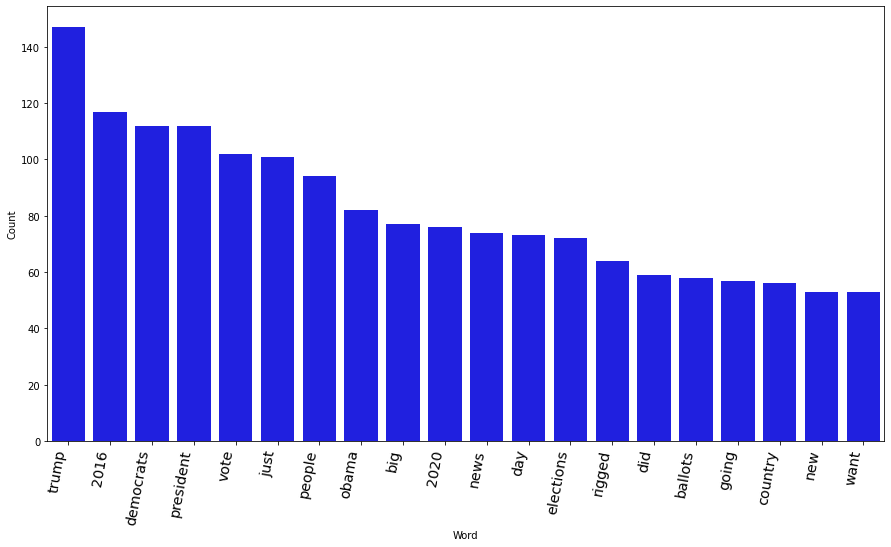

In [63]:
plot_contextual_election_words(list_top_contextual_election_words)

This graph shows that Trump mentioned the 2016 election more than the 2020 election, probably his campaigning was different in the two elections and influenced the final result. He also had to make himself known more in 2016 than 2020.

# Top '#'

We make an analysis of the most used hashtags in Trump's tweets

In [65]:
rdd_hashtags = rdd_trump_text_words.filter(lambda line : line.startswith('#'))\
                                    .map(lambda word: (word,1))\
                                    .reduceByKey(lambda x,y : x+y)\
                                    .sortBy(lambda tuple: tuple[1], ascending=False)

list_top_hashtags = rdd_hashtags.take(30)  

list_top_hashtags

[('#trump2016', 799),
 ('#makeamericagreatagain', 531),
 ('#maga', 475),
 ('#celebapprentice', 297),
 ('#celebrityapprentice', 150),
 ('#1', 141),
 ('#trump', 121),
 ('#timetogettough', 100),
 ('#americafirst', 94),
 ('#trumpvlog', 78),
 ('#trumpforpresident', 76),
 ('#draintheswamp', 75),
 ('#votetrump', 69),
 ('#covid19', 66),
 ('#trump2016https', 66),
 ('#kag2020', 63),
 ('#bigleaguetruth', 54),
 ('#2a', 50),
 ('#imwithyou', 48),
 ('#debate', 46),
 ('#2016', 46),
 ('#demdebate', 42),
 ('#gopdebate', 40),
 ('#usmca', 40),
 ('#trumptrain', 40),
 ('#crookedhillary', 38),
 ('#fitn', 38),
 ('#coronavirus', 36),
 ('#tbt', 35),
 ('#maga🇺🇸', 31)]

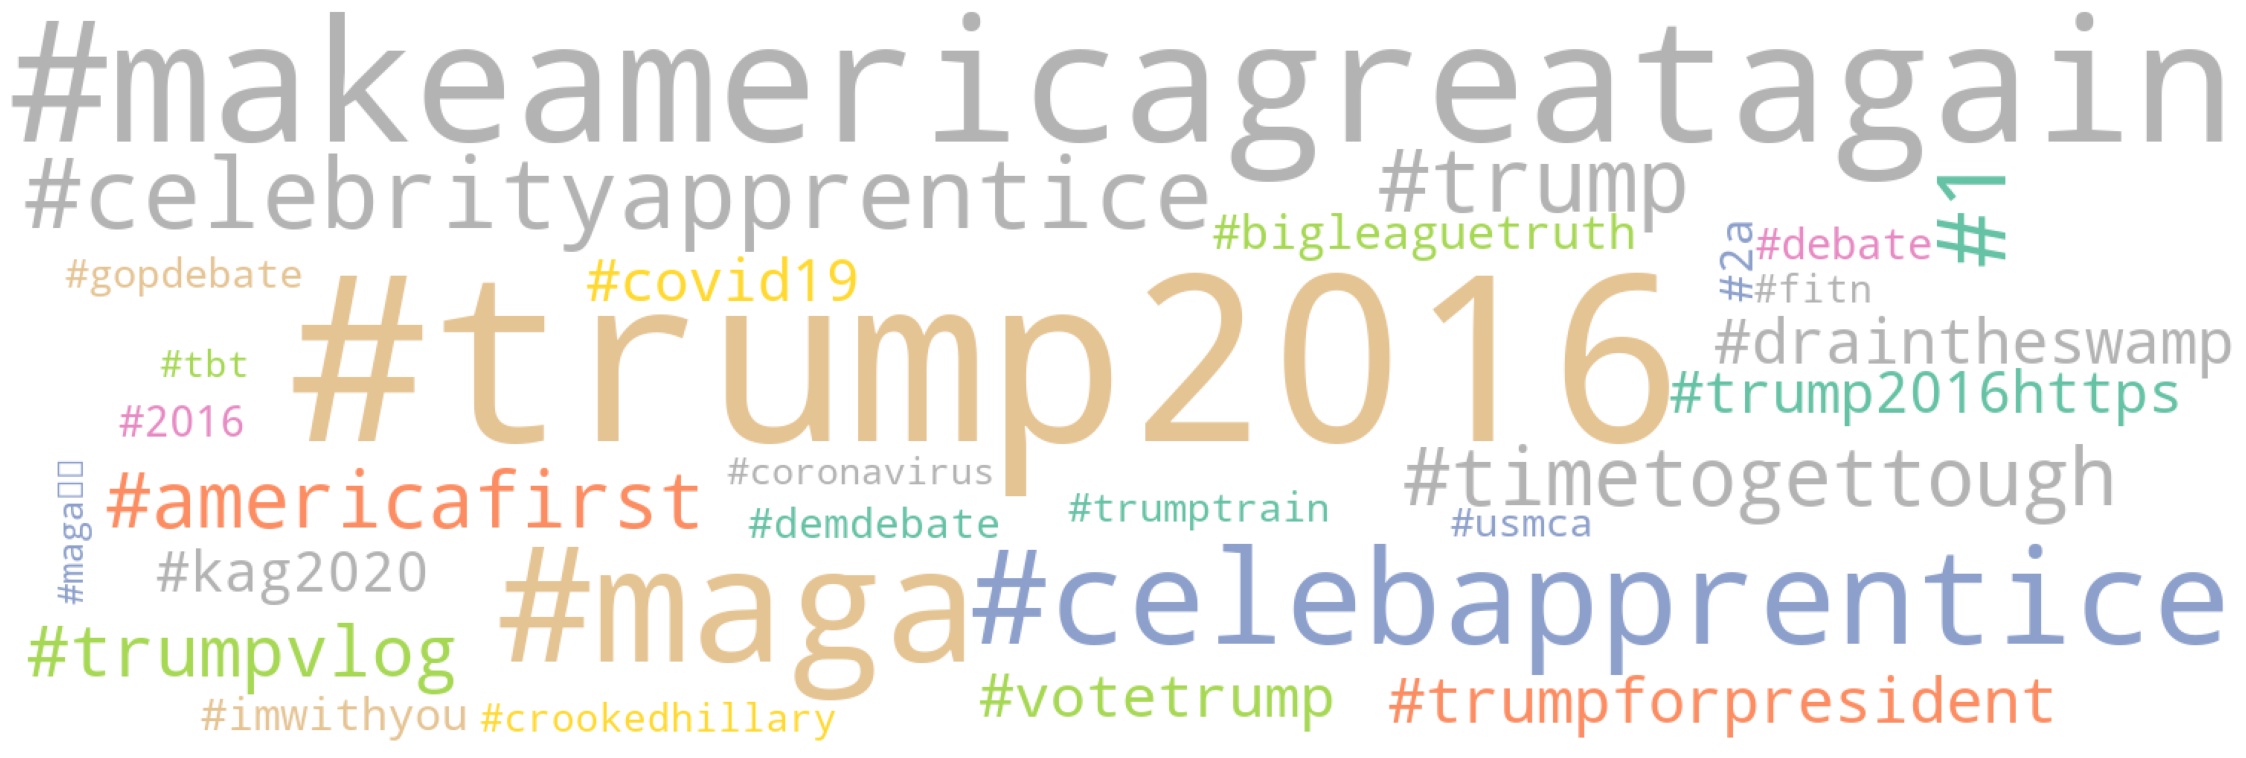

In [66]:
plot_cloud(list_top_hashtags)

Among the most used hashtags we find many important slogans used by Trump in the last decade: #trump2016 certainly related to the election, #makeamericagreatagain (and the acronim #maga) related to the 2016 election campaign and many other hashtags related to the world of politics.

# Top @

We do an analysis of the most tagged people in Trump's tweets

In [67]:
rdd_at = rdd_trump_text_words.filter(lambda line : line.startswith('@'))\
                                    .map(lambda word: (word,1))\
                                    .reduceByKey(lambda x,y : x+y)\
                                    .sortBy(lambda tuple: tuple[1], ascending=False)

list_top_at = rdd_at.take(30)  

list_top_at

[('@realdonaldtrump', 10763),
 ('@foxnews', 927),
 ('@whitehouse', 836),
 ('@foxandfriends', 703),
 ('@barackobama', 567),
 ('@cnn', 393),
 ('@apprenticenbc', 390),
 ('@seanhannity', 309),
 ('@ivankatrump', 302),
 ('@teamtrump', 295),
 ('@mittromney', 268),
 ('@gop', 243),
 ('@donaldjtrumpjr', 221),
 ('@gopchairwoman', 218),
 ('@danscavino', 213),
 ('@nytimes', 206),
 ('@erictrump', 200),
 ('@breitbartnews', 180),
 ('@potus', 170),
 ('@jim_jordan', 166),
 ('@megynkelly', 156),
 ('@flotus', 151),
 ('@dbongino', 143),
 ('@marklevinshow', 141),
 ('@greggjarrett', 140),
 ('@oreillyfactor', 136),
 ('@loudobbs', 135),
 ('@celebapprentice', 128),
 ('@macys', 128),
 ("@barackobama's", 127)]

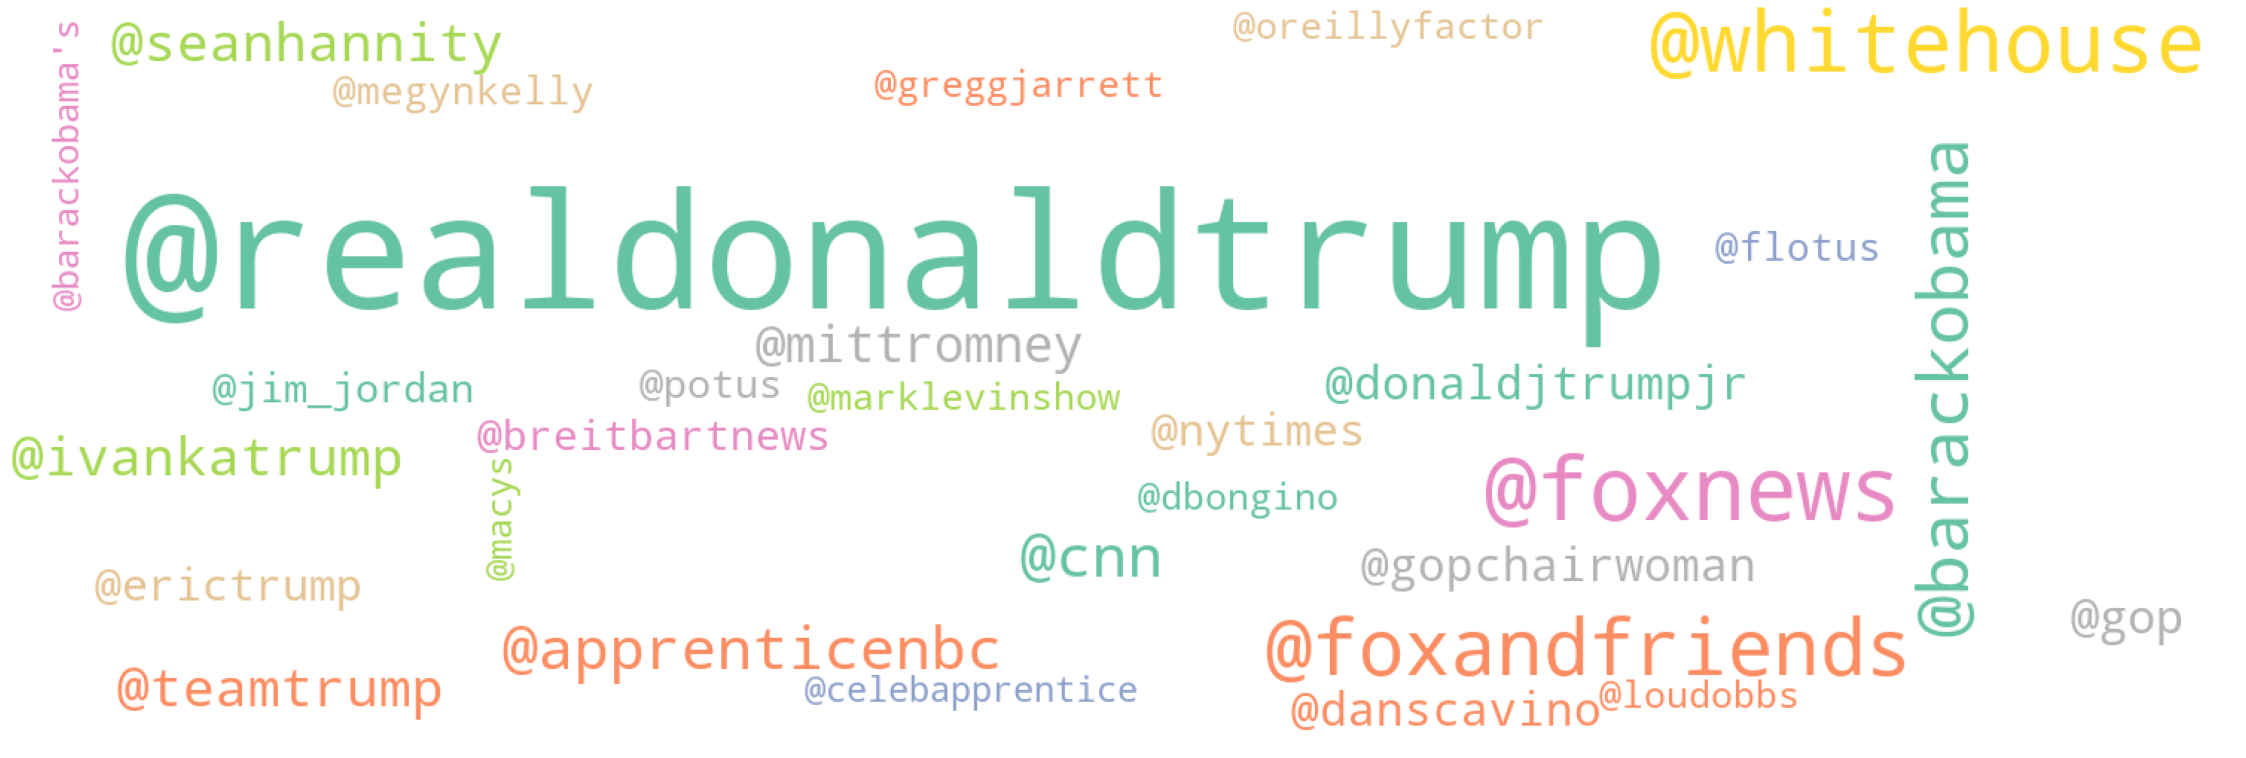

In [68]:
plot_cloud(list_top_at)

The most quoted person in Trump's tweets is himself (thanks to other people's retweets) and then mainly TV channels, newspapers or other people related to politics stand out.

## <span style="color:blue"> 2 - Time analysis </span>

We want to do an analysis of the years and hours of the day when Trump tweeted most: the problem is that some tweets are split over several lines, but since we are only interested in the dates, we filter out the lines where we only have the dates, and then extract them and delete the part of the text that comes before.

In [69]:
rdd_trump_tweets_cleaned = rdd_trump_tweets.filter(lambda tweet: ';' in tweet)

rdd_trump_tweets_cleaned.take(20)

['Republicans and Democrats have both created our economic problems.;02/08/2011 18:07:48',
 'I was thrilled to be back in the Great city of Charlotte, North Carolina with thousands of hardworking American Patriots who love our Country, cherish our values, respect our laws, and always put AMERICA FIRST! Thank you for a wonderful evening!! #KAG2020 https://t.co/dNJZfRsl9y;03/03/2020 01:34:50',
 'RT @CBS_Herridge: READ: Letter to surveillance court obtained by CBS News questions where there will be further disciplinary action and cho…;17/01/2020 03:22:47',
 'The Unsolicited Mail In Ballot Scam is a major threat to our Democracy, &amp  the Democrats know it. Almost all recent elections using this system, even though much smaller &amp   with far fewer Ballots to count, have ended up being a disaster. Large numbers of missing Ballots &amp  Fraud!;12/09/2020 20:10:58',
 "RT @MZHemingway: Very friendly telling of events here about Comey's apparent leaking to compliant media. If you read those 

The number of dates present, also indicates the total number of tweets Trump has made from 2009 to 2020

In [70]:
rdd_numbers_of_tweets = rdd_trump_tweets_cleaned.count()

print('The data contain',rdd_numbers_of_tweets,'tweets')

The data contain 55514 tweets


We identify the month and year in which Trump tweeted the most

In [71]:
rdd_trump_date = rdd_trump_tweets_cleaned.map(lambda tweet: (tweet.split(';')[1]).split(' ')[0])\
                                         .map(lambda line: line[3:])\
                                         .map(lambda date : (date, 1))\
                                         .reduceByKey(lambda a,b : a+b)\
                                        .map(lambda a: (a[1], a[0]))\
                                        .sortByKey(False)\
                                     


rdd_trump_date.take(20)

[(1415, '10/2020'),
 (1363, '09/2020'),
 (1126, '12/2019'),
 (1121, '08/2020'),
 (1121, '05/2020'),
 (1119, '06/2020'),
 (1119, '01/2015'),
 (1018, '10/2019'),
 (970, '03/2020'),
 (964, '01/2020'),
 (902, '04/2013'),
 (899, '02/2020'),
 (893, '02/2013'),
 (869, '07/2020'),
 (865, '07/2013'),
 (862, '11/2019'),
 (840, '04/2020'),
 (826, '03/2013'),
 (798, '04/2015'),
 (797, '09/2019')]

The period in which Trump tweeted the most was the autumn of 2020: although he was already president at that time, the election was imminent and Trump wanted to make his voice heard by the American people on Twitter as well.

We visualize the hours of the day in which Trump tweeted the most

In [73]:
rdd_trump_hour = rdd_trump_tweets_cleaned.map(lambda tweet: (tweet.split(';')[1]).split(' ')[1].split(':')[0])\
                        .map(lambda hour : (hour, 1))\
                        .reduceByKey(lambda a,b : a+b)\
                        .map(lambda a: (a[1], a[0]))\
                        .sortByKey(False)\

list_trump_hour = rdd_trump_hour.take(24)  

list_trump_hour

[(3851, '12'),
 (3637, '20'),
 (3425, '19'),
 (3347, '13'),
 (3141, '11'),
 (3038, '14'),
 (2955, '18'),
 (2944, '02'),
 (2891, '21'),
 (2840, '15'),
 (2732, '01'),
 (2575, '03'),
 (2571, '16'),
 (2367, '22'),
 (2305, '00'),
 (2270, '17'),
 (2203, '23'),
 (1887, '04'),
 (1694, '10'),
 (890, '05'),
 (667, '09'),
 (482, '06'),
 (436, '08'),
 (366, '07')]

In [74]:
def plot_amount_tweet_per_hour(trump_hour):
    
    pd_df = pd.DataFrame({
        'Hour':  [ t[1] for t in trump_hour ],
        'Nb_of_tweet': [ t[0] for t in trump_hour ]
    }).sort_values('Hour', ascending=True)
    
    plt.figure( figsize = (15, 8) )
    
    chart=sb.barplot(data=pd_df, x='Hour', y='Nb_of_tweet', order=pd_df['Hour'], color='red')
    
    chart.set_xticklabels(
        chart.get_xticklabels(), 
        rotation=80, 
        horizontalalignment='right',
        fontweight='light',
        fontsize='x-large',
        )
    
    plt.show()

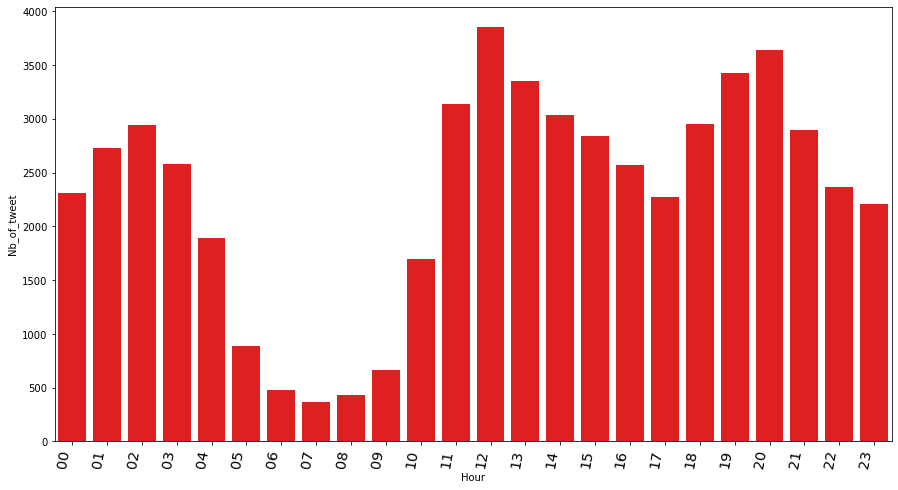

In [75]:
plot_amount_tweet_per_hour(list_trump_hour)

Trump prefers to tweet in the early afternoon or in the evening: surprisingly, there is a fairly high number of tweets even at night, while he tweets very little in the morning.

We visualize the years in which Trump tweeted the most

In [76]:
rdd_trump_year = rdd_trump_tweets_cleaned.map(lambda tweet: (tweet.split(';')[1]))\
                                         .map(lambda tweet: (tweet.split(' ')[0]))\
                                         .map(lambda tweet: (tweet.split('/')[2]))\
                                         .map(lambda year : (year, 1))\
                                         .reduceByKey(lambda a,b : a+b)\
                                         .map(lambda a: (a[1], a[0]))\
                                         .sortByKey(False)\

rdd_trump_year.take(12)

list_trump_year = rdd_trump_year.take(12)  

list_trump_year

[(11335, '2020'),
 (8144, '2013'),
 (7818, '2019'),
 (7536, '2015'),
 (5784, '2014'),
 (4225, '2016'),
 (3568, '2018'),
 (3531, '2012'),
 (2602, '2017'),
 (773, '2011'),
 (142, '2010'),
 (56, '2009')]

In [77]:
def plot_amount_tweet_per_year(trump_year):
    
    pd_df = pd.DataFrame({
        'Year':  [ t[1] for t in trump_year ],
        'Nb_of_tweet': [ t[0] for t in trump_year ]
    }).sort_values('Year', ascending=True)
    
    plt.figure( figsize = (15, 8) )
    
    chart=sb.barplot(data=pd_df, x='Year', y='Nb_of_tweet', order=pd_df['Year'], color='purple')
    
    chart.set_xticklabels(
        chart.get_xticklabels(), 
        rotation=80, 
        horizontalalignment='right',
        fontweight='light',
        fontsize='x-large',
        )
    
    plt.show()

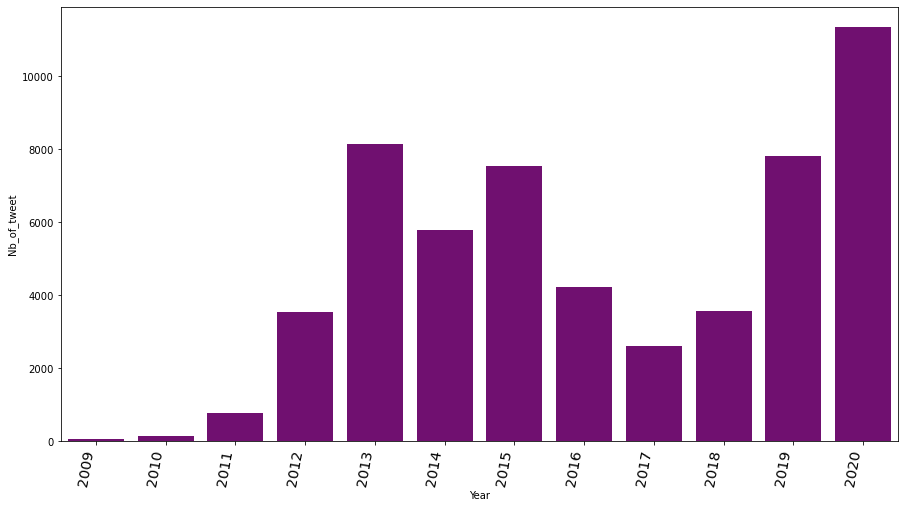

In [78]:
plot_amount_tweet_per_year(list_trump_year)

The years in which Trump tweeted the most were the years before the election, whereas he tweeted very little in the first years he was in office (2009, 2010) when social media were not yet mass media, and he tweeted very little even in the two years after he was elected president (2017 and 2018)